<a href="https://colab.research.google.com/github/PCJimmmy/Beverage-Factory/blob/master/Copy_of_Landmark_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Easy Landmark Image Recognition with TensorFlow Hub DELF Module](https://www.dlology.com/blog/easy-landmark-image-recognition-with-tensorflow-hub-delf-module/) | DLology Blog

### Download the images

In [0]:
!wget -q https://github.com/Tony607/Landmark-Retrival/releases/download/untagged-dcddb4fac5ceb8d69580/images.tar.gz
!tar -xzf images.tar.gz

In [2]:
!ls images

building_images  buildings.csv	Extras	query_buildings  resized


In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
from six.moves.urllib.request import urlopen

import glob
import os
from itertools import accumulate

np.random.seed(10)

W0411 18:00:32.909468 140664752236416 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [0]:
# IMAGE_1_URL = 'https://images.unsplash.com/photo-1522184808165-a39a75502037?ixlib=rb-0.3.5&ixid=eyJhcHBfaWQiOjEyMDd9&s=9058a9f269234b4d7b6dc7bd7066d7e8&auto=format&fit=crop&w=1350&q=80'
# IMAGE_2_URL = 'https://images.unsplash.com/photo-1479660656269-197ebb83b540?ixlib=rb-0.3.5&ixid=eyJhcHBfaWQiOjEyMDd9&s=88b85498e4c076fce0ed0c086543afb6&auto=format&fit=crop&w=1952&q=80'

IMAGE_1_URL = './images/Extras/p1.jpg'
IMAGE_2_URL = './images/Extras/p2.jpg'

In [0]:
# The names that will be used for the resized local images.

IMAGE_1_JPG = 'image_1.jpg'
IMAGE_2_JPG = 'image_2.jpg'

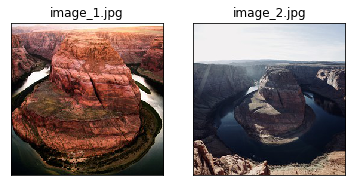

In [6]:
#@title The images that will be processed by DELF
def download_and_resize_image(url, filename, new_width=256, new_height=256):
    if 'http' in url:
        response = urlopen(url)
        image_data = response.read()
        pil_image = Image.open(BytesIO(image_data))
    else:
        pil_image = Image.open(url)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert('RGB')
    pil_image_rgb.save(filename, format='JPEG', quality=90)

download_and_resize_image(IMAGE_1_URL, IMAGE_1_JPG)
download_and_resize_image(IMAGE_2_URL, IMAGE_2_JPG)

def show_images(image_path_list):
    plt.figure()
    for i, image_path in enumerate(image_path_list):
        plt.subplot(1, len(image_path_list), i+1)
        plt.imshow(np.asarray(Image.open(image_path)))
        plt.title(image_path)
        plt.grid(False)
        plt.yticks([])
        plt.xticks([])
    plt.show()

show_images([IMAGE_1_JPG, IMAGE_2_JPG])

In [0]:
def image_input_fn(image_files):
    filename_queue = tf.train.string_input_producer(
        image_files, shuffle=False)
    reader = tf.WholeFileReader()
    _, value = reader.read(filename_queue)
    image_tf = tf.image.decode_jpeg(value, channels=3)
    return tf.image.convert_image_dtype(image_tf, tf.float32)

In [8]:
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.FATAL)

m = hub.Module('https://tfhub.dev/google/delf/1')

# The module operates on a single image at a time, so define a placeholder to
# feed an arbitrary image in.
image_placeholder = tf.placeholder(
    tf.float32, shape=(None, None, 3), name='input_image')

module_inputs = {
    'image': image_placeholder,
    'score_threshold': 100.0,
    'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
    'max_feature_num': 1000,
}

module_outputs = m(module_inputs, as_dict=True)

image_tf = image_input_fn([IMAGE_1_JPG, IMAGE_2_JPG])

with tf.train.MonitoredSession() as sess:
    results_dict = {}  # Stores the locations and their descriptors for each image
    for image_path in [IMAGE_1_JPG, IMAGE_2_JPG]:
        image = sess.run(image_tf)
        print('Extracting locations and descriptors from %s' % image_path)
        results_dict[image_path] = sess.run(
            [module_outputs['locations'], module_outputs['descriptors']],
            feed_dict={image_placeholder: image})

Extracting locations and descriptors from image_1.jpg
Extracting locations and descriptors from image_2.jpg


Loaded image 1's 193 features
Loaded image 2's 227 features


/usr/local/lib/python3.6/dist-packages/skimage/transform/_geometric.py:684: RuntimeWarning: divide by zero encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]
/usr/local/lib/python3.6/dist-packages/skimage/measure/fit.py:931: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


Found 24 inliers


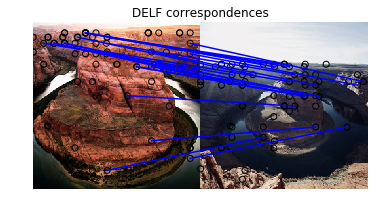

In [9]:
#@title TensorFlow is not needed for this post-processing and visualization
def match_images(results_dict, image_1_path, image_2_path):
    distance_threshold = 0.8

    # Read features.
    locations_1, descriptors_1 = results_dict[image_1_path]
    num_features_1 = locations_1.shape[0]
    print("Loaded image 1's %d features" % num_features_1)
    locations_2, descriptors_2 = results_dict[image_2_path]
    num_features_2 = locations_2.shape[0]
    print("Loaded image 2's %d features" % num_features_2)

    # Find nearest-neighbor matches using a KD tree.
    d1_tree = cKDTree(descriptors_1)
    _, indices = d1_tree.query(
        descriptors_2, distance_upper_bound=distance_threshold)

  # Select feature locations for putative matches.
    locations_2_to_use = np.array([
        locations_2[i,]
        for i in range(num_features_2)
        if indices[i] != num_features_1
    ])
    locations_1_to_use = np.array([
        locations_1[indices[i],]
        for i in range(num_features_2)
        if indices[i] != num_features_1
    ])

  # Perform geometric verification using RANSAC.
    _, inliers = ransac(
        (locations_1_to_use, locations_2_to_use),
        AffineTransform,
        min_samples=3,
        residual_threshold=20,
        max_trials=1000)
    # the number of inliers as the score for retrieved images.
    print('Found %d inliers' % sum(inliers))

    # Visualize correspondences.
    _, ax = plt.subplots()
    img_1 = mpimg.imread(image_1_path)
    img_2 = mpimg.imread(image_2_path)
    inlier_idxs = np.nonzero(inliers)[0]
    plot_matches(
        ax,
        img_1,
        img_2,
        locations_1_to_use,
        locations_2_to_use,
        np.column_stack((inlier_idxs, inlier_idxs)),
        matches_color='b')
    ax.axis('off')
    ax.set_title('DELF correspondences')
    plt.show()

match_images(results_dict, IMAGE_1_JPG, IMAGE_2_JPG)


In [10]:
import csv
import codecs
building_descs = []
f = codecs.open('./images/buildings.csv', 'rU', encoding='utf-8-sig')
reader = csv.reader(f)
for utf8_row in reader:
    building_descs.append(utf8_row[0])
building_descs

['1. Hagia Sophia — Istanbul, Turkey',
 '2. The Guggenheim — New York City, USA',
 '3. Taj Mahal — Agra, India',
 '4. Dancing House — Prague, Czech Republic',
 '5. Château de Chenonceau — Chenonceaux, France',
 '6. Niterói Contemporary Art Museum — Niterói, Rio de Janeiro, Brazil',
 '7. The Pyramids of Giza — Giza, Egypt',
 '8. Acropolis of Athens — Athens, Greece',
 '9. Centre Georges Pompidou  — Paris, France',
 '10. The Gateway Arch — St. Louis, Missouri, USA',
 "11. Musée d'Orsay — Paris, France",
 '12. The Gherkin — London, UK',
 '13. Notre-Dame Cathedral — Paris, France',
 '14. Mosque of Córdoba — Córdoba, Spain',
 '15. Westminster Abbey — London, UK',
 '16. Dresden Frauenkirche — Dresden, Germany',
 '17. Château Frontenac — Québec, Canada',
 '18. The Colosseum — Rome, Italy',
 '19. One World Trade Center — New York City, USA',
 '20. The Lotus Temple — New Delhi, India',
 '21. St. Basil’s Cathedral — Moscow, Russia',
 '22. Dome of the Rock — Jerusalem, Israel',
 '23. Casa Milà — 

## Resize all database images

In [0]:
def resize_image(srcfile, destfile, new_width=256, new_height=256):
    pil_image = Image.open(srcfile)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert('RGB')
    pil_image_rgb.save(destfile, format='JPEG', quality=90)
    return destfile
def resize_images_folder(srcfolder, destfolder='./images/resized', new_width=256, new_height=256):
    os.makedirs(destfolder,exist_ok=True)
    for srcfile in glob.iglob(os.path.join('./images/building_images', '*.[Jj][Pp][Gg]')):
        src_basename = os.path.basename(srcfile)
        destfile=os.path.join(destfolder,src_basename)
        resize_image(srcfile, destfile, new_width, new_height)
    return destfolder
def get_resized_db_image_paths(destfolder='./images/resized'):
    return sorted(list(glob.iglob(os.path.join(destfolder, '*.[Jj][Pp][Gg]'))))

In [0]:
resize_images_folder('./images/building_images')
db_images = get_resized_db_image_paths()

In [13]:
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.FATAL)

m = hub.Module('https://tfhub.dev/google/delf/1')

# The module operates on a single image at a time, so define a placeholder to
# feed an arbitrary image in.
image_placeholder = tf.placeholder(
    tf.float32, shape=(None, None, 3), name='input_image')

module_inputs = {
    'image': image_placeholder,
    'score_threshold': 100.0,
    'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
    'max_feature_num': 1000,
}

module_outputs = m(module_inputs, as_dict=True)

image_tf = image_input_fn(db_images)

with tf.train.MonitoredSession() as sess:
  results_dict = {}  # Stores the locations and their descriptors for each image
  for image_path in db_images:
    image = sess.run(image_tf)
    print('Extracting locations and descriptors from %s' % image_path)
    results_dict[image_path] = sess.run(
        [module_outputs['locations'], module_outputs['descriptors']],
        feed_dict={image_placeholder: image})

Extracting locations and descriptors from ./images/resized/pic_001.jpg
Extracting locations and descriptors from ./images/resized/pic_002.jpg
Extracting locations and descriptors from ./images/resized/pic_003.jpg
Extracting locations and descriptors from ./images/resized/pic_004.jpg
Extracting locations and descriptors from ./images/resized/pic_005.jpg
Extracting locations and descriptors from ./images/resized/pic_006.jpg
Extracting locations and descriptors from ./images/resized/pic_007.jpg
Extracting locations and descriptors from ./images/resized/pic_008.jpg
Extracting locations and descriptors from ./images/resized/pic_009.jpg
Extracting locations and descriptors from ./images/resized/pic_010.jpg
Extracting locations and descriptors from ./images/resized/pic_011.jpg
Extracting locations and descriptors from ./images/resized/pic_012.jpg
Extracting locations and descriptors from ./images/resized/pic_013.jpg
Extracting locations and descriptors from ./images/resized/pic_014.jpg
Extrac

In [0]:
def compute_locations_and_descriptors(image_path):
    tf.reset_default_graph()
    tf.logging.set_verbosity(tf.logging.FATAL)

    m = hub.Module('https://tfhub.dev/google/delf/1')

    # The module operates on a single image at a time, so define a placeholder to
    # feed an arbitrary image in.
    image_placeholder = tf.placeholder(
        tf.float32, shape=(None, None, 3), name='input_image')

    module_inputs = {
        'image': image_placeholder,
        'score_threshold': 100.0,
        'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
        'max_feature_num': 1000,
    }

    module_outputs = m(module_inputs, as_dict=True)

    image_tf = image_input_fn([image_path])

    with tf.train.MonitoredSession() as sess:
        image = sess.run(image_tf)
        print('Extracting locations and descriptors from %s' % image_path)
        return sess.run(
            [module_outputs['locations'], module_outputs['descriptors']],
            feed_dict={image_placeholder: image})

### Aggregate all database images' locations and descriptors to lists
Calculate accumulated/aggregated indexes boundaries per image so we can reverse search the image index given an accumulated/aggregated index.

In [0]:
locations_agg = np.concatenate([results_dict[img][0] for img in db_images])
descriptors_agg = np.concatenate([results_dict[img][1] for img in db_images])
accumulated_indexes_boundaries = list(accumulate([results_dict[img][0].shape[0] for img in db_images]))

### Build KD tree with database images' descriptors

In [0]:
d_tree = cKDTree(descriptors_agg) # build the KD tree

## Query a new image

In [0]:
query_image = './images/query_buildings/q1.jpg'
def preprocess_query_image(imagepath):
    '''
    Resize the query image and return the resized image path.
    '''
    query_temp_folder_name = 'query_temp_folder'
    query_temp_folder = os.path.join(os.path.dirname(query_image), query_temp_folder_name)
    os.makedirs(query_temp_folder,exist_ok=True)
    query_basename = os.path.basename(query_image)
    destfile=os.path.join(query_temp_folder,query_basename)
    resized_image = resize_image(query_image, destfile)
    return resized_image

resized_image = preprocess_query_image(query_image)

In [18]:
query_image_locations, query_image_descriptors = compute_locations_and_descriptors(resized_image)

Extracting locations and descriptors from ./images/query_buildings/query_temp_folder/q1.jpg


### Query the KD tree to find K nearest neighbors for each descriptor.

In [0]:
distance_threshold = 0.8
# K nearest neighbors
K = 10
distances, indices = d_tree.query(
    query_image_descriptors, distance_upper_bound=distance_threshold, k = K, n_jobs=-1)

# Find the list of unique accumulated/aggregated indexes
unique_indices = np.array(list(set(indices.flatten())))

unique_indices.sort()
if unique_indices[-1] == descriptors_agg.shape[0]:
    unique_indices = unique_indices[:-1]

## Get a list of database candidate image indexes
Look up a list of unique image indexes, each image contains at least one of K nearest neighbor result descriptors.
By reverse indexes look up.

In [20]:
unique_image_indexes = np.array(
    list(set([np.argmax([np.array(accumulated_indexes_boundaries)>index]) 
              for index in unique_indices])))
unique_image_indexes

array([ 2,  3,  4,  7, 10, 12, 16, 17, 20, 21, 22, 23, 25, 26, 32, 34, 36,
       40, 41, 42, 45, 46, 47])

In [0]:
def image_index_2_accumulated_indexes(index, accumulated_indexes_boundaries):
    '''
    Image index to accumulated/aggregated locations/descriptors pair indexes.
    '''
    if index > len(accumulated_indexes_boundaries) - 1:
        return None
    accumulated_index_start = None
    accumulated_index_end = None
    if index == 0:
        accumulated_index_start = 0
        accumulated_index_end = accumulated_indexes_boundaries[index]
    else:
        accumulated_index_start = accumulated_indexes_boundaries[index-1]
        accumulated_index_end = accumulated_indexes_boundaries[index]
    return np.arange(accumulated_index_start,accumulated_index_end)

In [0]:
def get_locations_2_use(image_db_index, k_nearest_indices, accumulated_indexes_boundaries):
    '''
    Get a pair of locations to use, the query image to the database image with given index.
    Return: a tuple of 2 numpy arrays, the locations pair.
    '''
    image_accumulated_indexes = image_index_2_accumulated_indexes(image_db_index, accumulated_indexes_boundaries)
    locations_2_use_query = []
    locations_2_use_db = []
    for i, row in enumerate(k_nearest_indices):
        for acc_index in row:
            if acc_index in image_accumulated_indexes:
                locations_2_use_query.append(query_image_locations[i])
                locations_2_use_db.append(locations_agg[acc_index])
                break
    return np.array(locations_2_use_query), np.array(locations_2_use_db)
            

### Perform geometric verification using RANSAC and visualization

Found inliers for image 2 -> 3


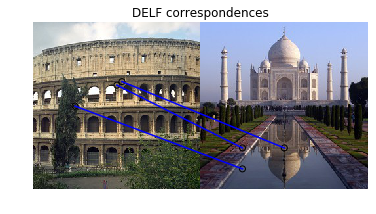

/usr/local/lib/python3.6/dist-packages/skimage/transform/_geometric.py:684: RuntimeWarning: divide by zero encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]
/usr/local/lib/python3.6/dist-packages/skimage/measure/fit.py:931: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold
/usr/local/lib/python3.6/dist-packages/skimage/transform/_geometric.py:684: RuntimeWarning: invalid value encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]


Found inliers for image 4 -> 11


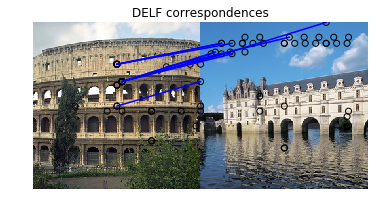

Found inliers for image 7 -> 5


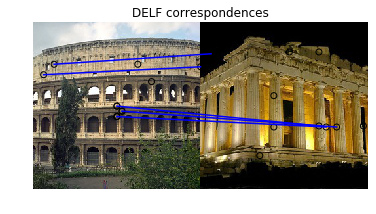

Found inliers for image 10 -> 10


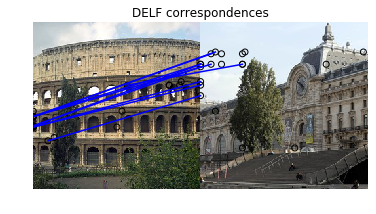

Found inliers for image 12 -> 7


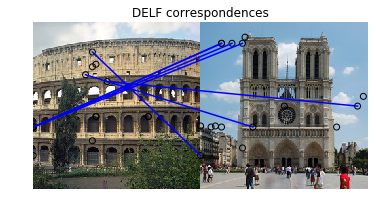

Found inliers for image 17 -> 29


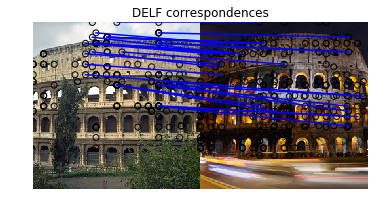

Found inliers for image 21 -> 7


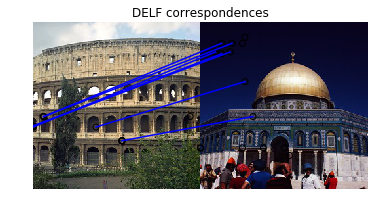

Found inliers for image 22 -> 8


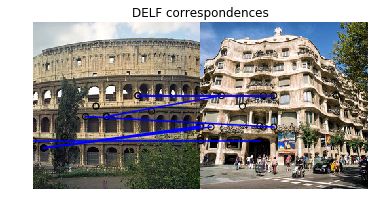

Found inliers for image 23 -> 3


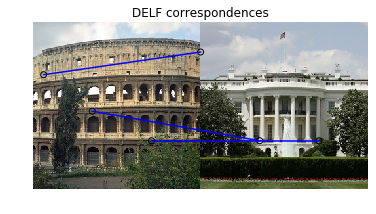

Found inliers for image 34 -> 6


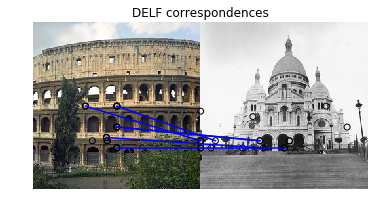

Found inliers for image 36 -> 10


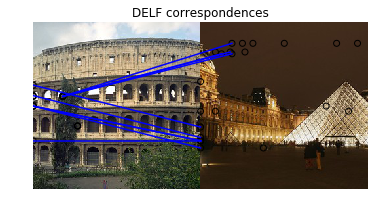

Found inliers for image 40 -> 4


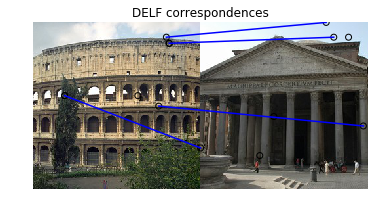

Found inliers for image 45 -> 5


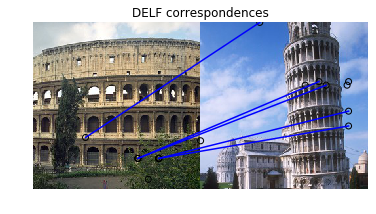

In [23]:
# Array to keep track of all candidates in database.
inliers_counts = []
# Read the resized query image for plotting.
img_1 = mpimg.imread(resized_image)
for index in unique_image_indexes:
    locations_2_use_query, locations_2_use_db = get_locations_2_use(index, indices, accumulated_indexes_boundaries)
    # Perform geometric verification using RANSAC.
    _, inliers = ransac(
        (locations_2_use_db, locations_2_use_query), # source and destination coordinates
        AffineTransform,
        min_samples=3,
        residual_threshold=20,
        max_trials=1000)
    # If no inlier is found for a database candidate image, we continue on to the next one.
    if inliers is None or len(inliers) == 0:
        continue
    # the number of inliers as the score for retrieved images.
    inliers_counts.append({"index": index, "inliers": sum(inliers)})
    print('Found inliers for image {} -> {}'.format(index, sum(inliers)))
    # Visualize correspondences.
    _, ax = plt.subplots()
    img_2 = mpimg.imread(db_images[index])
    inlier_idxs = np.nonzero(inliers)[0]
    plot_matches(
        ax,
        img_1,
        img_2,
        locations_2_use_db,
        locations_2_use_query,
        np.column_stack((inlier_idxs, inlier_idxs)),
        matches_color='b')
    ax.axis('off')
    ax.set_title('DELF correspondences')
    plt.show()

In [24]:
inliers_counts

[{'index': 2, 'inliers': 3},
 {'index': 4, 'inliers': 11},
 {'index': 7, 'inliers': 5},
 {'index': 10, 'inliers': 10},
 {'index': 12, 'inliers': 7},
 {'index': 17, 'inliers': 29},
 {'index': 21, 'inliers': 7},
 {'index': 22, 'inliers': 8},
 {'index': 23, 'inliers': 3},
 {'index': 34, 'inliers': 6},
 {'index': 36, 'inliers': 10},
 {'index': 40, 'inliers': 4},
 {'index': 45, 'inliers': 5}]

### Show the top match result
Employ the number of inliers as the score for retrieved images.

Best guess for this image: 18. The Colosseum — Rome, Italy


/usr/local/lib/python3.6/dist-packages/skimage/transform/_geometric.py:684: RuntimeWarning: divide by zero encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]
/usr/local/lib/python3.6/dist-packages/skimage/measure/fit.py:931: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold
/usr/local/lib/python3.6/dist-packages/skimage/transform/_geometric.py:684: RuntimeWarning: invalid value encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]


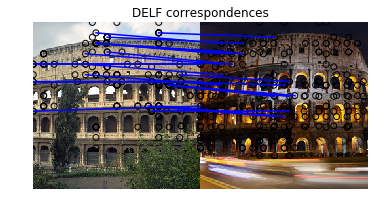

In [25]:
top_match = sorted(inliers_counts, key=lambda k: k['inliers'], reverse=True)[0]

index = top_match['index']
print('Best guess for this image:', building_descs[index])
locations_2_use_query, locations_2_use_db = get_locations_2_use(index, indices, accumulated_indexes_boundaries)
# Perform geometric verification using RANSAC.
_, inliers = ransac(
    (locations_2_use_db, locations_2_use_query), # source and destination coordinates
    AffineTransform,
    min_samples=3,
    residual_threshold=20,
    max_trials=1000)
# Visualize correspondences.
_, ax = plt.subplots()
img_2 = mpimg.imread(db_images[index])
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(
    ax,
    img_1,
    img_2,
    locations_2_use_db,
    locations_2_use_query,
    np.column_stack((inlier_idxs, inlier_idxs)),
    matches_color='b')
ax.axis('off')
ax.set_title('DELF correspondences')
plt.show()